In [1]:
import tensorflow as tf
import os
import pathlib
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

tf.__version__

'2.1.0'

# Data Pipelines
Input pipelines need to be efficient to make best use of GPU hardware. `tf.data.Dataset` represents the input pipeline. 

`Dataset.from_tensor_slices()` - slices the tensor you give it

## For Tensors

In [2]:
tf.data.Dataset.from_tensor_slices()

TypeError: from_tensor_slices() missing 1 required positional argument: 'tensors'

In [ ]:
tf.data.Dataset.map() #Maps `map_func` across the elements of this dataset
tf.data.Dataset.batch() #Combines consecutive elements of this dataset into batches.
tf.data.Dataset.shuffle() #Randomly shuffles the elements of this dataset.

`.map()`,`.batch()`, and `.shuffle()` to create preprocessing pipelines on batches.

In [ ]:
tf.data.Dataset.filter() #Filters this dataset according to mask function.
tf.data.Dataset.prefetch() #Creates a Dataset that prefetches elements from this dataset.

`.prefetch()`examples.batch(20).prefetch(2) will prefetch 2 elements (2 batches, of 20 examples each).

In [ ]:
tf.data.Dataset.take() #Creates a `Dataset` with at most n elements from this dataset.

`td.data.TextLineDataset` generates a dataset from each line in a text file.


## For Images
Image dataset is Tiny ImageNet [source](https://tiny-imagenet.herokuapp.com/)

In [3]:
dir_path = "E://Data/Imagenet/tiny-imagenet-200/"
NUM_CLASSES = 200
BATCH_SIZE=128

def show_batch(train_data_gen):
    """Implementing something similar to FastAIs showbatch method
    Outputs a 3x3 grid of images from the image data generator"""
    image_batch, label_batch = next(train_data_gen)
    plt.figure(figsize=(10,10))
    CLASSES = np.array(list(train_data_gen.class_indices.keys()))  #get the label order directly from iterator (otherwise will mixup)
    for n in range(9):
        ax = plt.subplot(3,3,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASSES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.show()
    
def Example_CNN_Model(num_blocks, convs_per_block):
    """
    Example Convolutional Neural Network for Image data.
    Example_CNN_Model(num_blocks, convs_per_block)
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(64,64,3),
                                   batch_size=BATCH_SIZE))
    filters = 64
    for i in range(num_blocks):
        for j in range(convs_per_block):
            model.add(tf.keras.layers.Conv2D(filters*(i+1),
                                                  (3,3), 
                                                  padding='same',
                                                  activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.GlobalAvgPool2D())
    model.add(tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"))
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['acc'])
    return model

In [4]:
CLASSES = os.listdir(os.path.join(dir_path,"train"))
print("Example classes:",CLASSES[:5])
print("Number of classes:",len(CLASSES))

Example classes: ['abacus', 'academic gown', 'acorn', 'African elephant', 'albatross']
Number of classes: 200


### Keras `ImageDataGenerator` API

In [5]:
data_root = os.path.join(dir_path,"train")
#define the tranformations
transforms = {'width_shift_range':0.1,
              'height_shift_range':0.1,
              'validation_split':0.2,
              "rescale":1/255.
             }
#Create the generator with spectified transforms
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(**transforms)

#create generators from data directory
train_imgs =  image_gen.flow_from_directory(data_root,
                                           target_size = (64,64),
                                           batch_size = BATCH_SIZE,
                                            subset='training')
valid_imgs =  image_gen.flow_from_directory(data_root,
                                           target_size = (64,64),
                                           batch_size = BATCH_SIZE,
                                            subset='validation')

Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


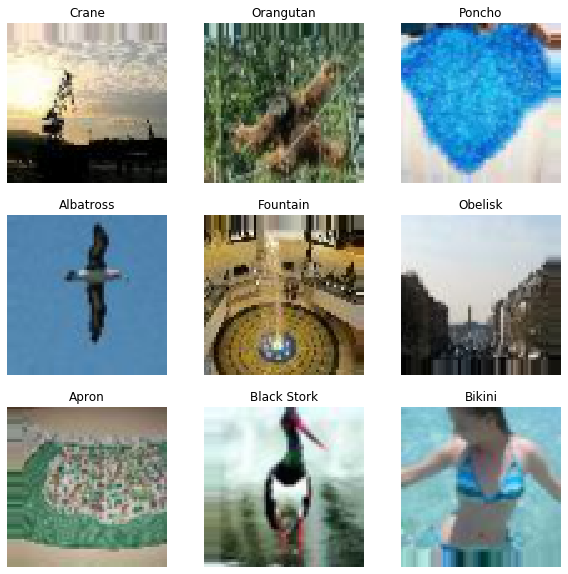

In [6]:
show_batch(train_imgs)

In [10]:
model = Example_CNN_Model(3, 3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (128, 64, 64, 64)         1792      
_________________________________________________________________
batch_normalization_9 (Batch (128, 64, 64, 64)         256       
_________________________________________________________________
conv2d_10 (Conv2D)           (128, 64, 64, 64)         36928     
_________________________________________________________________
batch_normalization_10 (Batc (128, 64, 64, 64)         256       
_________________________________________________________________
conv2d_11 (Conv2D)           (128, 64, 64, 64)         36928     
_________________________________________________________________
batch_normalization_11 (Batc (128, 64, 64, 64)         256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (128, 32, 32, 64)        

In [11]:
#STEPS_PER_EPOCH = train_imgs.samples//BATCH_SIZE
#VALID_STEPS_PER_EPOCH = valid_imgs.samples//BATCH_SIZE
EPOCHS=5
checkpoint_path = 'E://Models/ImageNet-200/1/'

cb = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 verbose=1')
]

#use_multiprocessing on generator makes training faster
history = model.fit(train_imgs,
           #steps_per_epoch=STEPS_PER_EPOCH,
           epochs=EPOCHS,
           validation_data=valid_imgs,
           callbacks=cb,
           workers=-1,
           use_multiprocessing=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625 steps, validate for 157 steps
Epoch 1/5
625/625 [==============================] - 791s 1s/step - loss: 4.3903 - acc: 0.0873 - val_loss: 4.2547 - val_acc: 0.0925
Epoch 2/5
625/625 [==============================] - 163s 261ms/step - loss: 3.6580 - acc: 0.1846 - val_loss: 3.7772 - val_acc: 0.1622
Epoch 3/5
625/625 [==============================] - 161s 258ms/step - loss: 3.2303 - acc: 0.2592 - val_loss: 3.4138 - val_acc: 0.2343
Epoch 4/5
625/625 [==============================] - 161s 258ms/step - loss: 2.8999 - acc: 0.3210 - val_loss: 3.0435 - val_acc: 0.2985
Epoch 5/5
625/625 [==============================] - 161s 258ms/step - loss: 2.6428 - acc: 0.3734 - val_loss: 2.8802 - val_acc: 0.3281


In [12]:
model.save(checkpoint_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: E://Models/ImageNet-200/1/assets


# Afterward

Things that could be improved:
- Figure out how to monitor GPU utilization
- Figure out way to calculate best batch size 
- Figure out how to implement fit_one_cycle (and test whether this is faster)
- Look at other peoples implementations and examine their pipeline choices